In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

caffe_root = '/home/alex/Caffe/caffe/'
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# This just customizes a few aspects of the plots
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Check if the file can be found
import os
if not os.path.isfile(caffe_root + 'models/hybridCNN/hybridCNN_iter_700000.caffemodel'):
    print("Model not found")

Set up the transformer to receive images for classification and the networks that we'll be using. These are based on the examples given earlier. https://github.com/BVLC/caffe/issues/290 for the method

In [2]:
from caffe.proto import caffe_pb2
blob = caffe_pb2.BlobProto()
data = open(caffe_root + 'models/hybridCNN/hybridCNN_mean.binaryproto').read()
blob.ParseFromString(data)
arr = np.array(caffe.io.blobproto_to_array(blob))

This is purely to visualise the mean values. I've kept it only because the result that was produced was so trippy

(3, 256, 256)


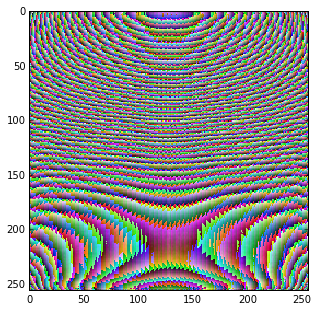

In [3]:
im = arr.squeeze()
print im.shape
plt.imshow(im.transpose(1,2,0))

Note that here the dimensions of the array mean are 2's instead of 1's. This is a small quirk due to the fact that the mean given with the trained model has an extra dimension (1) in front of all of the others. This could be dealt with by squeezing before, but I've done this instead. See for yourself with arr.mean(2).mean(2)

In [4]:
caffe.set_mode_cpu()
net = caffe.Net('deploy.prototxt',
                caffe_root + 'models/hybridCNN/hybridCNN_iter_700000.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', arr.mean(2).mean(2).squeeze()) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Quickly see the shape of the network to check what we're expecting to get out of it

In [5]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 227, 227)),
 ('conv1', (1, 96, 55, 55)),
 ('pool1', (1, 96, 27, 27)),
 ('norm1', (1, 96, 27, 27)),
 ('conv2', (1, 256, 27, 27)),
 ('pool2', (1, 256, 13, 13)),
 ('norm2', (1, 256, 13, 13)),
 ('conv3', (1, 384, 13, 13)),
 ('conv4', (1, 384, 13, 13)),
 ('conv5', (1, 256, 13, 13)),
 ('pool5', (1, 256, 6, 6)),
 ('fc6', (1, 4096)),
 ('fc7', (1, 4096)),
 ('fc8', (1, 1183)),
 ('prob', (1, 1183))]

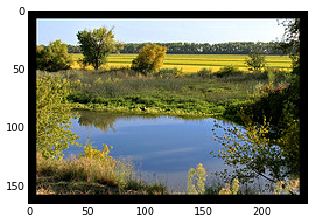

In [10]:
net.blobs['data'].reshape(1,3,227,227)
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image('../100001.jpg'))
out = net.forward()
plt.imshow(caffe.io.load_image('../100001.jpg'))

In [11]:
out['prob'].argmax()

962

In [12]:
out['prob'].argsort()[0][-5:]

array([479, 425, 347, 956, 962])